# REALIZAR O TRATAMENTO DOS DADOS DE LOGS E UTILIZA-LOS COMO FONTE PARA A GERAÇÃO DOS INDICADORES

## Importar bibliotecas necessárias

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from datetime import timedelta
matplotlib.style.use('ggplot')
%matplotlib inline


## Cria as funções para cálculo de duração das atividades

In [47]:

def clamp(t, start, end):
    "Return `t` clamped to the range [`start`, `end`]."
    return max(start, min(end, t))

def day_part(t):
    "Return timedelta between midnight and `t`."
    return t - t.replace(hour = 0, minute = 0, second = 0)

def fun_diferenca_tempo_util(a, b, start = timedelta(hours = 8),
                        stop = timedelta(hours = 20)):
    """
    Return the total office time between `a` and `b` as a timedelta
    object. Office time consists of weekdays from `start` to `stop`
    (default: 08:00 to 17:00).
    """
    zero = timedelta(0)
    assert(zero <= start <= stop <= timedelta(1))
    office_day = stop - start
    days = (b - a).days + 1
    weeks = days // 7
    extra = (max(0, 5 - a.weekday()) + min(5, 1 + b.weekday())) % 5
    if ((days < 7 )& (extra ==0 )):
        weeks =1
    weekdays = weeks * 5 + extra
    total = office_day * weekdays
    if a.weekday() < 5:
        total -= clamp(day_part(a) - start, zero, office_day)
    if b.weekday() < 5:
        total -= clamp(stop - day_part(b), zero, office_day)
    horas = round(total.total_seconds()/3600,4)
    return horas


## Confere os tipos de dados do arquivo

In [48]:
dadoslogs.dtypes

ideventolog                              int64
nomefluxo                             category
eventosituacaosolicitacao             category
situacaofinalsolicitacao              category
idsolicitacao                            int64
agrupamento                              int64
atividade                             category
transicaoatividade                    category
areaexecucaoatividade                 category
papelexecucaoatividade                  object
nomerecursoexecucaoatividade            object
datahoraeventolog               datetime64[ns]
gruposervico                          category
servico                               category
operacaoservico                       category
tiposolicitacao                       category
prioridade                               int64
origemsolicitacao                     category
tempoatendimentoslaservico             float64
tempoatendimentoslachamado             float64
arearesponsavelservico                category
dtype: object

* __Avalia os volumes de registros de cada tipo atividade e transição de atividade__

In [49]:
dadoslogs_group = pd.groupby(dadoslogs, \
    by=[dadoslogs.atividade, dadoslogs.transicaoatividade])
dadosvolume = dadoslogs_group.size().sort_values(ascending=False)
dadosvolume

atividade        transicaoatividade
FILA DE ESPERA   start                 38156
                 complete              38156
ATENDIMENTO      start                 29842
                 complete              29842
ABERTURA         complete              15657
FECHAMENTO       start                 15455
                 complete              15455
ENCERRAMENTO     complete              14699
RECLASSIFICAÇÃO  complete               6943
ATENDIMENTO      suspend                2845
                 resume                 2743
CANCELAMENTO     complete                682
REABERTURA       complete                175
dtype: int64

* __Verificar solicitações de serviços com mairo número de eventos registados__

In [50]:
dadoslogs_group = pd.groupby(dadoslogs, by=[dadoslogs.idsolicitacao])
dadosvolume = dadoslogs_group.size().sort_values(ascending=False)
dadosvolume.head()

idsolicitacao
20420    41
10681    40
4995     39
4806     38
6641     38
dtype: int64

## Realizar junção dos registros de star e complete para calcular a duração do evento de cada atividade

* __Cria data frame com apenas as columnas necessárias para o cálculo da duração das atividades__

In [51]:
subsetdados = dadoslogs[['ideventolog','idsolicitacao','agrupamento','atividade',\
                'areaexecucaoatividade','transicaoatividade','datahoraeventolog']]
#subsetdados = subsetdados[dadoslogs.idsolicitacao.isin([20420, 10681,4995,4806])]
subsetdados.head()

,ideventolog,idsolicitacao,agrupamento,atividade,areaexecucaoatividade,transicaoatividade,datahoraeventolog
0,37199,3031,31760,ABERTURA,PORTAL,complete,2014-10-01 07:32:00
1,37200,3031,31760,FILA DE ESPERA,OUTROS,start,2014-10-01 07:32:05
2,37201,3031,31760,FILA DE ESPERA,OUTROS,complete,2014-10-01 07:32:58
3,37202,3031,31885,ATENDIMENTO,OUTROS,start,2014-10-01 07:33:00
4,37203,3031,31885,ATENDIMENTO,OUTROS,complete,2014-10-01 09:42:58


* __Combina os data frames para unir os eventos e calcular a duração__

In [52]:
# Realizar o merge
combinada = pd.merge(subsetdados,subsetdados,\
                     on=['idsolicitacao','agrupamento','atividade',\
                         'areaexecucaoatividade'])
# Filtra os resultados
combinada = combinada[(combinada['transicaoatividade_x'] == 'start') \
                      & (combinada['transicaoatividade_y'] == 'complete')]

#Verifica  o resultado
combinada.head()

,ideventolog_x,idsolicitacao,agrupamento,atividade,areaexecucaoatividade,transicaoatividade_x,datahoraeventolog_x,ideventolog_y,transicaoatividade_y,datahoraeventolog_y
2,37200,3031,31760,FILA DE ESPERA,OUTROS,start,2014-10-01 07:32:05,37201,complete,2014-10-01 07:32:58
6,37202,3031,31885,ATENDIMENTO,OUTROS,start,2014-10-01 07:33:00,37203,complete,2014-10-01 09:42:58
11,37205,3031,31899,FILA DE ESPERA,CIT-NIVEL1,start,2014-10-01 09:43:05,37206,complete,2014-10-01 09:46:58
15,37207,3031,31900,FECHAMENTO,CIT-NIVEL1,start,2014-10-01 09:47:00,37208,complete,2014-10-01 09:48:00
20,37210,3032,31762,FILA DE ESPERA,OUTROS,start,2014-10-01 07:36:05,37211,complete,2014-10-01 07:36:58


In [53]:
# Calcula a duração dos eventos
combinada['duracaoHoras'] =  combinada.apply(lambda row:  \
                        fun_diferenca_tempo_util (row['datahoraeventolog_x'],\
                                                  row['datahoraeventolog_y'] ) ,axis=1)

#Verifica  o resultado
combinada[['ideventolog_x','datahoraeventolog_x',\
           'datahoraeventolog_y','duracaoHoras']].head()

,ideventolog_x,datahoraeventolog_x,datahoraeventolog_y,duracaoHoras
2,37200,2014-10-01 07:32:05,2014-10-01 07:32:58,0.0000
6,37202,2014-10-01 07:33:00,2014-10-01 09:42:58,1.7161
11,37205,2014-10-01 09:43:05,2014-10-01 09:46:58,0.0647
15,37207,2014-10-01 09:47:00,2014-10-01 09:48:00,0.0167
20,37210,2014-10-01 07:36:05,2014-10-01 07:36:58,0.0000


* __Como o tempo de duração foi considerado apenas o horário comercial, eventuais atividades realizadas nesse horário ficaram com duração igual a zero__




In [54]:
combinada['duracaozero']= combinada['duracaoHoras'] == 0.00

pd.pivot_table(combinada,index=["duracaozero"],\
               values=["ideventolog_x"],aggfunc=[len])


,len
,ideventolog_x
duracaozero,
False,83019
True,534


* Preencher duração 1 minuto nessas atividades para contabilizar o registros



In [55]:
combinada['duracaoHoras'] = combinada.apply(lambda row: \
                (row['duracaoHoras'],0.005)[row['duracaoHoras']==0],axis=1)

In [56]:
combinada['duracaozero']= combinada['duracaoHoras'] == 0.00

pd.pivot_table(combinada,index=["duracaozero"],\
               values=["ideventolog_x"],aggfunc=[len])


,len
,ideventolog_x
duracaozero,
False,83553


## Calcular o tempo de atendimento de cada solicitação de serviços

In [86]:
solicitacoesGroup = combinada[['idsolicitacao','duracaoHoras','atividade']]
solicitacoesGroup['atividade'].unique()
solicitacoesGroup = solicitacoesGroup[solicitacoesGroup['atividade'] <> 'FECHAMENTO']
solicitacoesGroup = solicitacoesGroup[['idsolicitacao','duracaoHoras']]
solicitacoesGroup = pd.groupby(solicitacoesGroup, by=[solicitacoesGroup.idsolicitacao])
solicitacoesTempoAtendimento = solicitacoesGroup.sum()

In [58]:
solicitacoesTempoAtendimento.sort_values('duracaoHoras').head()

,duracaoHoras
idsolicitacao,
16942,0.0150
20496,0.0150
5665,0.0455
8677,0.0461
8277,0.0461


In [59]:
solicitacoesTempoAtendimento.sort_values('duracaoHoras').tail()

,duracaoHoras
idsolicitacao,
3348,1342.1788
4705,1353.5455
3322,1358.8783
3225,1370.4423
3034,1403.5436


* __Verificar a distribuição do tempo de atendimento__

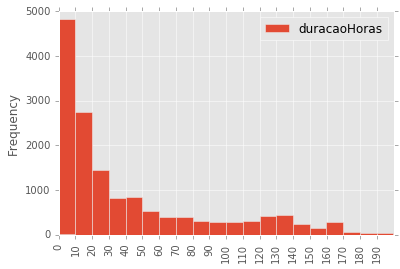

In [60]:
plt.figure();
solicitacoesTempoAtendimento[ solicitacoesTempoAtendimento['duracaoHoras'] <= 200].plot(\
    kind='hist', bins=20, xlim=[0,200], xticks=range(0,200,10), rot = 90)


## Criar um data frame com os dados básicos das solicitações para análise inicial

In [87]:
solicitacoes =  dadoslogs[['idsolicitacao', 'situacaofinalsolicitacao', \
                      'gruposervico', 'servico', 'operacaoservico', \
                      'tiposolicitacao', 'arearesponsavelservico']]

solicitacoes =  solicitacoes.drop_duplicates()


In [79]:
solicitacoes.sort_values('idsolicitacao').head()

,idsolicitacao,situacaofinalsolicitacao,gruposervico,servico,operacaoservico,tiposolicitacao,arearesponsavelservico
0,3031,FECHADA,APLICAÇÕES,PONTO DA SOF,DIAGNOSTICAR ERROS E FALHAS,INCIDENTE,CIT-SISTEMAS
10,3032,FECHADA,E-MAIL,EXPRESSO V3,DIAGNOSTICAR ERROS E FALHAS,INCIDENTE,CIT-SISTEMAS
20,3033,FECHADA,APLICAÇÕES,SEI (SISTEMA ELETRÔNICO DE INFORMAÇÕES),CADASTRAR USUÁRIO,REQUISIÇÃO,CIT-SISTEMAS
35,3034,CANCELADA,ARMAZENAMENTO DE DADOS,SERVIDOR DE ARQUIVOS (PDCMP),CONFIGURACAO DO ARMAZENAMENTO,REQUISIÇÃO,DTI-SUPORTE
50,3037,FECHADA,SUPORTE,ESTAÇÃO DE TRABALHO,TROCAR MOUSE,REQUISIÇÃO,CIT-PRES-DF


In [88]:
solicitacoesTempoAtendimento = solicitacoesTempoAtendimento.reset_index()
solicitacoesTempoAtendimento[['idsolicitacao','duracaoHoras']].head()


,idsolicitacao,duracaoHoras
0,3031,1.7858
1,3032,1.7692
2,3033,24.5168
3,3034,1403.5436
4,3037,74.7758


In [89]:
# Realizar o merge
solicitacoes = pd.merge(solicitacoes, solicitacoesTempoAtendimento,\
                     on=['idsolicitacao'])



In [91]:

solicitacoes.head()

,idsolicitacao,situacaofinalsolicitacao,gruposervico,servico,operacaoservico,tiposolicitacao,arearesponsavelservico,duracaoHoras
0,3031,FECHADA,APLICAÇÕES,PONTO DA SOF,DIAGNOSTICAR ERROS E FALHAS,INCIDENTE,CIT-SISTEMAS,1.7858
1,3032,FECHADA,E-MAIL,EXPRESSO V3,DIAGNOSTICAR ERROS E FALHAS,INCIDENTE,CIT-SISTEMAS,1.7692
2,3033,FECHADA,APLICAÇÕES,SEI (SISTEMA ELETRÔNICO DE INFORMAÇÕES),CADASTRAR USUÁRIO,REQUISIÇÃO,CIT-SISTEMAS,24.5168
3,3034,CANCELADA,ARMAZENAMENTO DE DADOS,SERVIDOR DE ARQUIVOS (PDCMP),CONFIGURACAO DO ARMAZENAMENTO,REQUISIÇÃO,DTI-SUPORTE,1403.5436
4,3037,FECHADA,SUPORTE,ESTAÇÃO DE TRABALHO,TROCAR MOUSE,REQUISIÇÃO,CIT-PRES-DF,74.7758


In [90]:
solicitacoes.dtypes

idsolicitacao                 int64
situacaofinalsolicitacao     object
gruposervico                 object
servico                      object
operacaoservico              object
tiposolicitacao              object
arearesponsavelservico       object
duracaoHoras                float64
dtype: object

In [92]:
solicitacoes['gruposervico'] = solicitacoes['gruposervico'].astype('category')
solicitacoes['servico'] = solicitacoes['servico'].astype('category')
solicitacoes['tiposolicitacao'] = solicitacoes['tiposolicitacao'].astype('category')
solicitacoes['situacaofinalsolicitacao'] = solicitacoes['situacaofinalsolicitacao'].astype('category')
solicitacoes['operacaoservico'] = solicitacoes['operacaoservico'].astype('category')
solicitacoes['arearesponsavelservico'] = solicitacoes['arearesponsavelservico'].astype('category')

In [93]:
solicitacoes.dtypes

idsolicitacao                  int64
situacaofinalsolicitacao    category
gruposervico                category
servico                     category
operacaoservico             category
tiposolicitacao             category
arearesponsavelservico      category
duracaoHoras                 float64
dtype: object

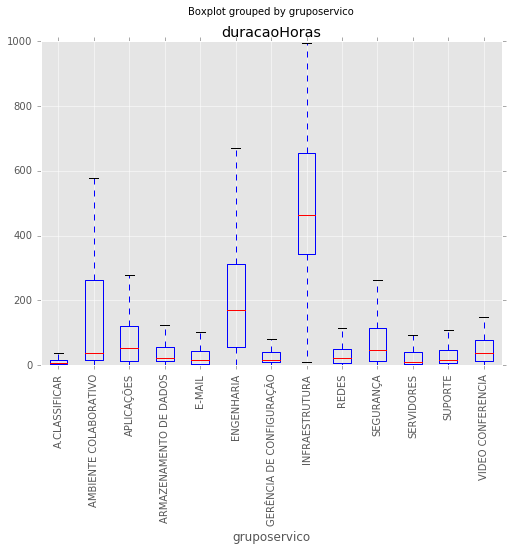

In [123]:
solicitacoes.boxplot(column='duracaoHoras', by='gruposervico',figsize=(8, 6), rot=90, sym='')

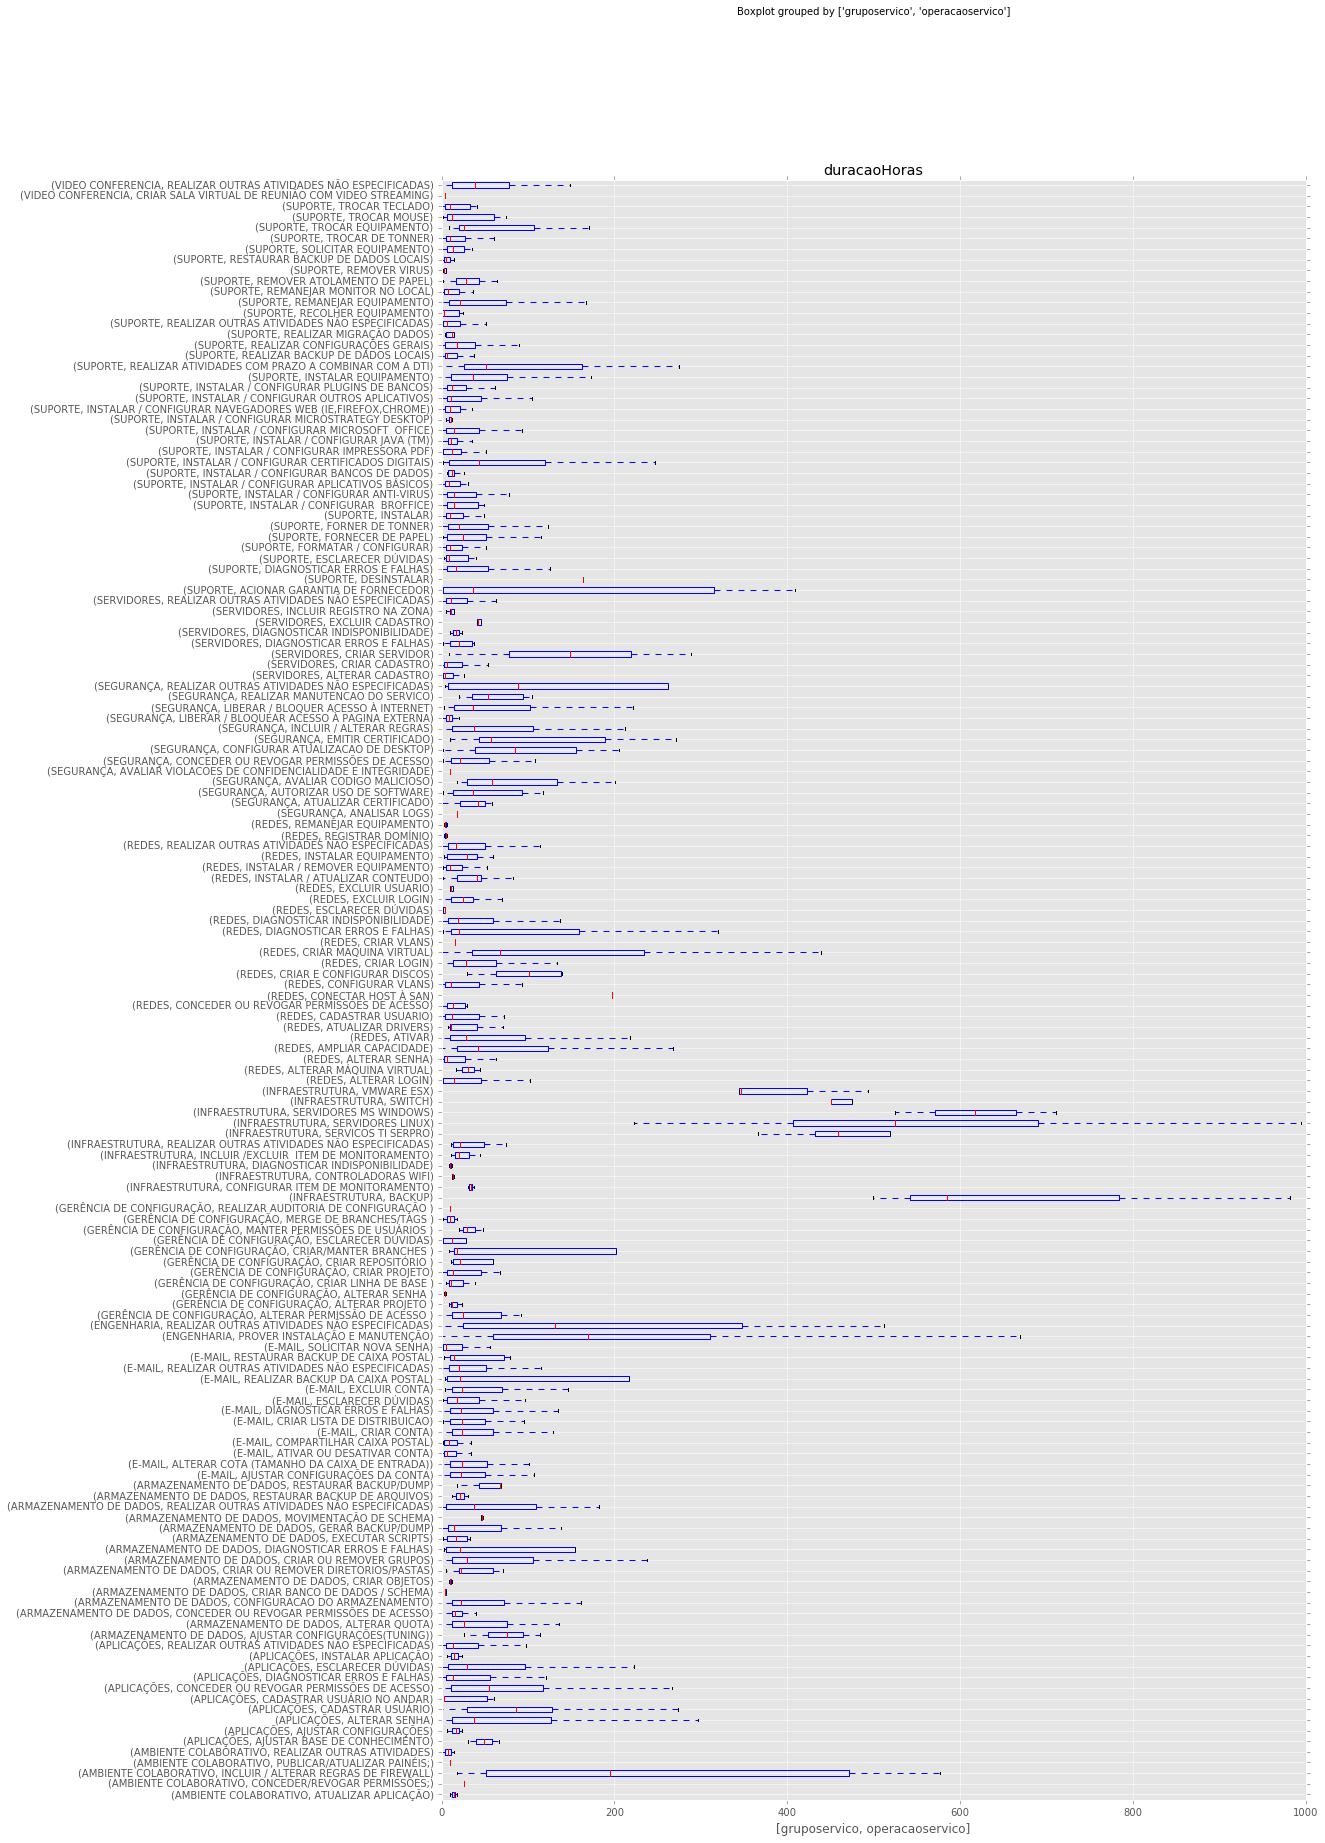

In [129]:
solicitacoes.boxplot(column='duracaoHoras', by=['gruposervico','operacaoservico'],figsize=(15, 30), rot=0, sym='',vert=False)

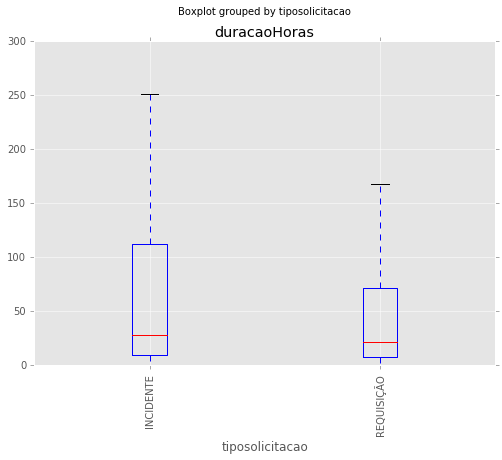

In [121]:
solicitacoes.boxplot(column='duracaoHoras', by='tiposolicitacao',figsize=(8, 6), rot=90, sym='')


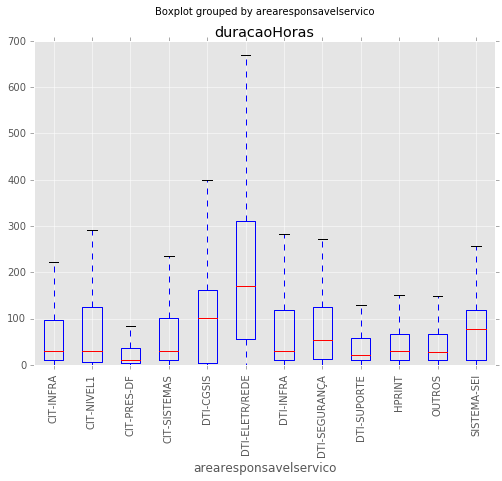

In [122]:
solicitacoes.boxplot(column='duracaoHoras', by='arearesponsavelservico',figsize=(8, 6), rot=90, sym='')

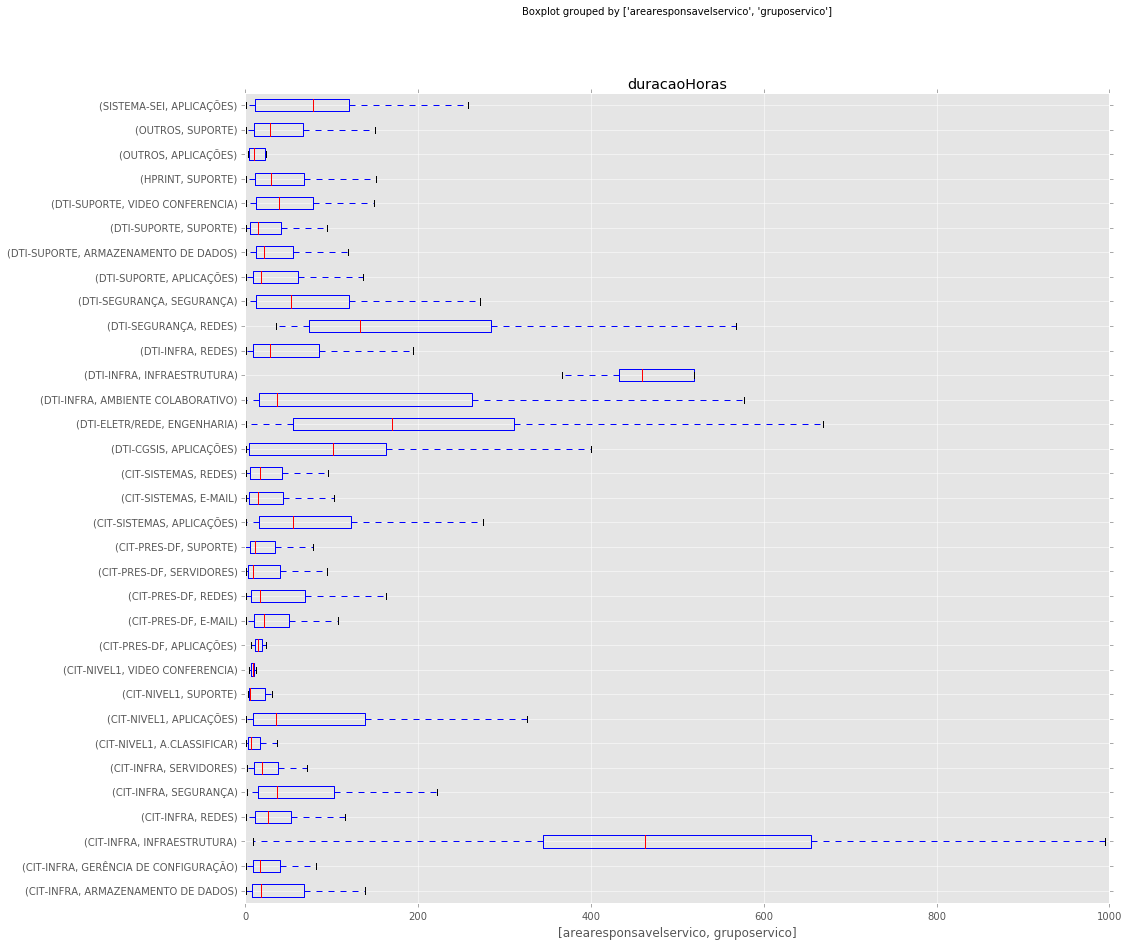

In [132]:
solicitacoes.boxplot(column='duracaoHoras', by=['arearesponsavelservico','gruposervico'],figsize=(15, 15), rot=0, sym='',vert=False)

## Proximos passos
* criar um dataframe com dados detalhados por atividade e área
* Avaliar a dipersão de tempo de atendimento por área
* dentro da área visualizar o box plot por grupo de serviço, pacote de sla 
* Colocar a data de abertura e encerramento das solicitações para permitir análises no tempo